#Movimiento de una partícula cargada en una lente magnética, cuadrupolo y sextupolo magnético.

## Modelaje del campo magnético y la dinámica de la partícula

In [72]:
#Librerias
from numpy import *
from numpy.fft import *
from scipy import *
from scipy.special import *
from scipy.integrate import *
from pylab import *
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Una lente magnética es un dispositivo que produce un campo magnético utilizado en microscopios electrónicos y en aceleraadores de partículas para focalizar un haz de electrones de la misma forma que lo hace una lente óptica con los rayos de luz.

Una lente mangética por lo general consiste en varios electroimanes organizados como cuadrupolo, sextupolo o ordenes mayores. Los electroimanes deben de estar el los vertices de polígonos regulares, es decir para formar un cuadrupolo se necesitan poner los electroimanes de forma alternada en los vertices de un cuadrado.

Primero tenemos que saber cual es el campo magnético creado por una espira en la cual pasa corriente de forma continua. Resulta que una espira centrada en el eje $Z$, de radio a y separada del plano $XY$ una distancia h entonces el campo producido por la espira en el punto $(r, z, \theta)$ tiene la siguiete forma en coordenadas cilindricas.

Si $r \neq 0$
$$B_{z} = \frac{\mu_{0} I}{4\pi} \frac{2}{\sqrt{(a+r)^{2}+(z-h)^{2}}} \left\lbrack K(k^{2}) + \frac{a^{2}-r^{2}-(z-h)^{2}}{(a-r)^{2}+(z-h)^{2}}E(k^{2}) \right\rbrack $$
$$B_{r} = \frac{\mu_{0} I}{4\pi}\frac{z-h}{r} \frac{2}{\sqrt{(a+r)^{2}+(z-h)^{2}}} \left\lbrack -K(k^{2}) + \frac{a^{2}+r^{2}+(z-h)^{2}}{(a-r)^{2}+(z-h)^{2}} E(k^{2}) \right\rbrack$$

$$B_{\theta} = 0$$
Si $r = 0$
$$B_{z} = \frac{\mu_{0}}{4\pi} \frac{2\pi a^{2} I}{\left((z-h)^{2}+a^{2}\right)^{3/2}}$$
$$B_{r} = 0$$
$$B_{\theta} = 0$$


Donde $K(k)$ y $E(k)$ son las integrales elípticas completas de primera y segunda especie respectivamente y $k^{2} = \frac{4ar}{(r+a)^{2}+(z-h)^{2}}$.

Poniendo todo en unidades de $\frac{\mu_0}{4\pi}$

In [73]:
#Se define la forma que va a tener el campo magnetico
#Las variables que hay que considerar son las siguientes
# I->      la corriente
# a->      el radio de la espira
# h->      la altura a la que se encuentra la espira
# r_vec->  el punto en el espacio en el cual queremos calcular el campo magnético

def campo_mag(I, a, h, r_vec, f=0):
    # r_vec va a estar dado en coordenadas cilindricas (r, z, phi)
    r = r_vec[0]
    z = r_vec[1]

    #f va a servir de bandera ya que el campo magnetico depende del valor de r
    if f==0:
    # si r <> 0 entonces 
        k2 = (4*a*r)/((r+a)**2+(z-h)**2)
        B_z = I*(2/sqrt((a+r)**2+(z-h)**2))*(ellipk(k2) + ellipe(k2)*((a**2-r**2-(z-h)**2)/((a-r)**2+(z-h)**2)))
        B_r = I*((z-h)/r)*(2/sqrt((a+r)**2+(z-h)**2))*(-ellipk(k2) + ellipe(k2)*((a**2+r**2+(z-h)**2)/((a-r)**2+(z-h)**2)))

    elif f==1:
    # si r = 0 entonces 
        B_r = 0.
        B_z = (2*pi*I*a**2)/sqrt((a**2+(z-h)**2)**3)

    return B_r, B_z

#Se define una funcion paa obtener el campo magnetico unitario
def campo_unit(I, a, r_vec, h=0, f=0):
    B_r, B_z = campo_mag(I, a, r_vec, h, f)
    B = sqrt(B_r**2+B_z**2)
    b_r, b_z = B_r/B, B_z/B
    return b_r, b_z, B

A continuación se grafica la dirección del campo magnétio generado por una espira de radio $a = 1$ sobre el plano $XY$ donde se le hace pasar corriente $I = 1$, la convención que se usará aquí es corriente positiva indica que circula sobre la espira en el sentido contrario a las manesillas del reloj y corriente negatica indica que circula sobre la espira en el sentido a las manesillas del reloj. El campo magnético al no depender el ángulo $\theta$ se realiza entonces en coordenadas cilindricas para $\theta$ arbitrario.

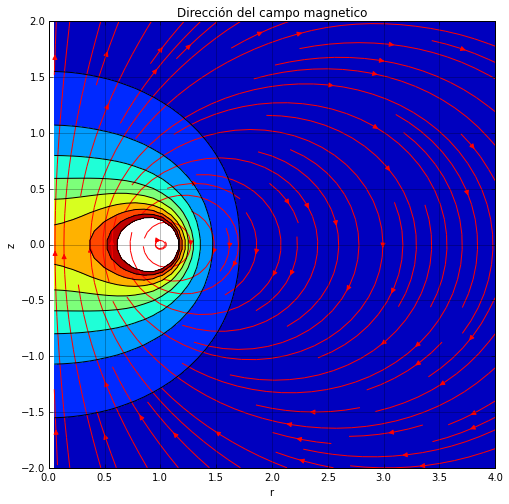

In [74]:
N_malla = 50
n, m = 4, 2
R_min, R_max, Z_min, Z_max = 0.05, n, -m, m

r, z = linspace(R_min, R_max, N_malla), linspace(Z_min, Z_max, N_malla)
R, Z = meshgrid(r,z)

I, a, h = 1., 1., 0.
b_r, b_z, B = campo_unit(I, a, h, [R, Z])

figure(figsize=(8,8),dpi=80)
contour_levels = arange(0., 10., 1.)
cs = contourf(R, Z, B, contour_levels , corner_mask=True)
contour(cs, colors='k')
grid(c='k', ls='-', alpha=0.5)
streamplot(R, Z, b_r, b_z, color='r')

gca().set_aspect('equal', adjustable='box')

xlabel('r') 
ylabel('z')
axis([0., R_max, Z_min, Z_max])
title(u'Dirección del campo magnetico')
show()

In [75]:
#Se define una funcion que va a calcular el campo magnetico de un arreglo de espiras
#La forma en que lo hace es haciendole pasar un arreglo de radios y alturas, a=[...], h=[...]
#y suma para cada caso, nota a, h e I deben de tener la misma dimension
def campo(I, a, h, r_vec, THETA, f=0):
    #El formato de r_vec es r_vec=(x,y,z)
    
    if len(r_vec)==3:
        x, y, z = r_vec[0], r_vec[1], r_vec[2]
    elif len(r_vec)==2:
        x, y, z = zeros((len(r_vec[0]),len(r_vec[1]))), r_vec[0], r_vec[1]

    B_x, B_y, B_z = 0., 0., 0.
    for i in range(len(h)):

    #Sistema intermedio
        #vector ya que rote el sistema a un sistema intermedio donde el eje de simetria de la espira
        #sea el nuevo eje z
        Rr_vec = array([x, y*cos(THETA[i])+z*sin(THETA[i]), -y*sin(THETA[i])+z*cos(THETA[i])])

        #Se cambia a coordenadas cilindricas (r, z)
        phi_int = arctan2(Rr_vec[1], Rr_vec[0])
        Rr = sqrt(Rr_vec[0]**2+Rr_vec[1]**2)
        Rr_vec_cil = array([Rr, Rr_vec[2]])
        
        #Se calcula el signo correcto de la corriente, la proyeccion del "eje z" de la espira
        #sobre el eje z del sistema

        if abs(THETA[i]) == pi/2:
            signoi = -1.
        if cos(THETA[i]) >= 0.:
            signoi = 1.
        else:signoi = -1.
        
        #Se calcula el campo magnetico en el sistemas donde la espira esta en el "eje z"
        B_interm_cil = campo_mag(signoi*I[i], a[i], h[i], Rr_vec_cil, f)

        #Se cambia a coordenadas cilindricas (x, y, z)
        Bi_interm_xyz = array([B_interm_cil[0]*cos(phi_int), B_interm_cil[0]*sin(phi_int), B_interm_cil[1]])
        
    #Cambio al sistema original
        #Se realiza la transformacion del campo magnetico a sistema original
        B_i = array([Bi_interm_xyz[0], Bi_interm_xyz[1]*cos(THETA[i])-Bi_interm_xyz[2]*sin(THETA[i]),
                     Bi_interm_xyz[1]*sin(THETA[i]) + Bi_interm_xyz[2]*cos(THETA[i])])
        
        B_x = B_x + B_i[0]
        B_y = B_y + B_i[1]
        B_z = B_z + B_i[2]

    return B_x, B_y, B_z

#Se calcula campo unitario para el caso de multiples espriras
def campo_unit2(I, a, h, r_vec, THETA, f=0):
    B_X, B_Y, B_Z = campo(I, a, h, r_vec, THETA, f)
    B = sqrt(B_X**2 + B_Y**2 + B_Z**2)
    b_x, b_y, b_z = B_X/B, B_Y/B, B_Z/B
    
    return b_x, b_y, b_z, B

A continuación se grafica la dirección del campo magnétio generado por dos espiras de radio a = 1 a una altura h=1 y h=-1, donde a la primera se le hace pasar corriente $I=1$ y a la segunda $I = -1$. Analogo al caso de una espira, el campo magnético al no depender el ángulo $\theta$ se realiza entonces en coordenadas cilindricas para $\theta$ arbitrario.

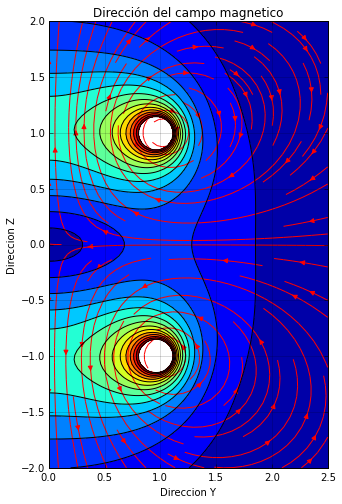

In [76]:
qm, I, a, h, theta = 1., [1., -1.], [1., 1.], [1., 1.], [0., pi]

N_malla = 100
n, m = 2.5, 2.
Y_min, Y_max, Z_min, Z_max = 0.00001, n, -m, m

y, z = linspace(Y_min, Y_max, N_malla), linspace(Z_min, Z_max, N_malla)
Y, Z = meshgrid(y,z)

b_x, b_y, b_z, B = campo_unit2(I, a, h, [Y,Z], theta)

figure(figsize=(10,8), dpi=80)
contour_levels = arange(0., 15., 1.)
cs = contourf(Y, Z, B, contour_levels , corner_mask=True)
contour(cs, colors='k')
grid(c='k', ls='-', alpha=0.3)
QP = streamplot(Y, Z, b_y, b_z, color='r')

plt.gca().set_aspect('equal', adjustable='box')
xlabel('Direccion Y') 
ylabel('Direccion Z')
axis([0., Y_max, Z_min, Z_max])
title(u'Dirección del campo magnetico')
show()

## Arreglo de las espiras

In [87]:
def graf_campo(ARGS, contorno = [0., 24., 2.], n = 2.5, m = 2.5):
    #ARGS tiene el siguiente formato [qm, I, a, h, THETA]    
    I, a, h, theta = ARGS[1], ARGS[2], ARGS[3], ARGS[4]

    N_malla = 200
    Y_min, Y_max, Z_min, Z_max = -n, n, -m, m

    y, z = linspace(Y_min, Y_max, N_malla), linspace(Z_min, Z_max, N_malla)
    Y, Z = meshgrid(y,z)

    b_x, b_y, b_z, B = campo_unit2(I, a, h, [Y,Z], theta)

    fig = figure(figsize=(17,17))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    angle = np.linspace(0, 2 * pi, 100)

    Angulos = theta

    for i in range(len(Angulos)):
        M = array([[cos(Angulos[i]), 0., -sin(Angulos[i])],
                    [0., 1., 0.],
                    [sin(Angulos[i]), 0., cos(Angulos[i])]])

        X = array([a[i]*cos(angle), a[i]*sin(angle), h[i]*ones(len(angle))])
        RX = dot(M, X)
        ax1.plot(RX[0], RX[1], RX[2])


    ax1.set_xlim3d(Y_min, Y_max)
    ax1.set_ylim3d(Y_min, Y_max)
    ax1.set_zlim3d(Z_min, Z_max)
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Z axis')
    ax1.set_aspect('equal', adjustable='box')
    ax1.view_init(10, 70)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.contour_levels = arange(contorno[0], contorno[1], contorno[2])
    cs = contourf(Y, Z, B, contour_levels , corner_mask=True)
    ax2.contour(cs, colors='k')
    ax2.grid(c='k', ls='-', alpha=0.3)
    ax2.streamplot(Y, Z, b_y, b_z, color='r')

    ax2.set_aspect('equal', adjustable='box')
    ax2.set_xlabel('Direccion Y') 
    ax2.set_ylabel('Direccion Z')
    ax2.axis([Y_min, Y_max, Z_min, Z_max])
    ax2.set_title(u'Dirección del campo magnético')

    show()

In [88]:
i, qm = 1., -1.

I_cuad, a_cuad = [i, -i, -i, -i], [1., 1., 1., 1.]
h_cuad, THETA_cuad = [1., 1., 1., 1.], [0., pi/2, pi, -pi/2]
ARGS_cuad = ([qm, I_cuad, a_cuad, h_cuad, THETA_cuad],)

I_hex, a_hex = [i, -i, -i, i, -i, -i], [1., 1., 1., 1., 1., 1.]
h_hex, THETA_hex = [sqrt(3.), sqrt(3.), sqrt(3.), sqrt(3.), sqrt(3.), sqrt(3.)], [0., pi/3, 2*pi/3, pi, -2*pi/3, -pi/3]
ARGS_hex = ([qm, I_hex, a_hex, h_hex, THETA_hex],)

### Cuadrupolo magnético

A continuación se dibuja el arreglo de las espiras para generar un cuadrupolo magnético. Por simplicidad las espiras se van a colocar parallelos a los ejes siendo el poligono regular un cuadrado orientado en forma diagonal sobre el plano $XZ$.

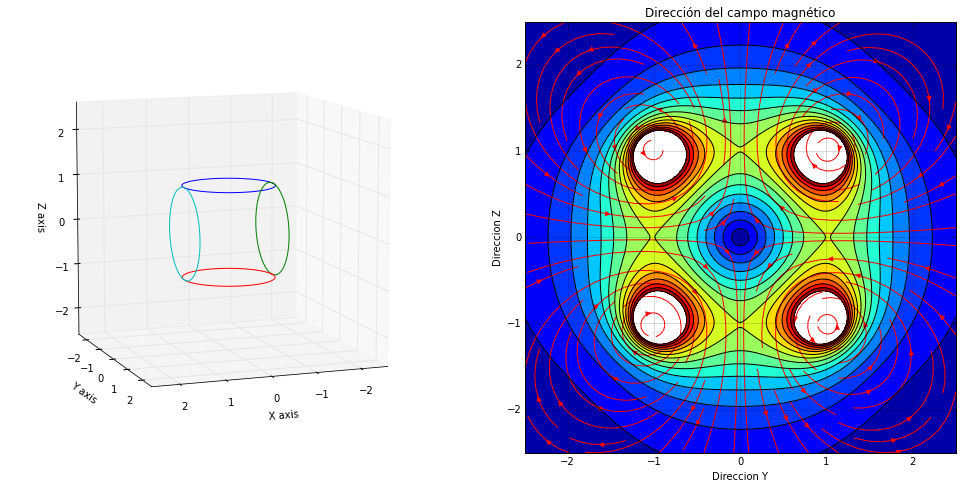

In [89]:
graf_campo(ARGS_cuad[0])

### Sextupolo magnético

A continuación se dibuja el arreglo de las espiras para generar un sextupolo magnético.

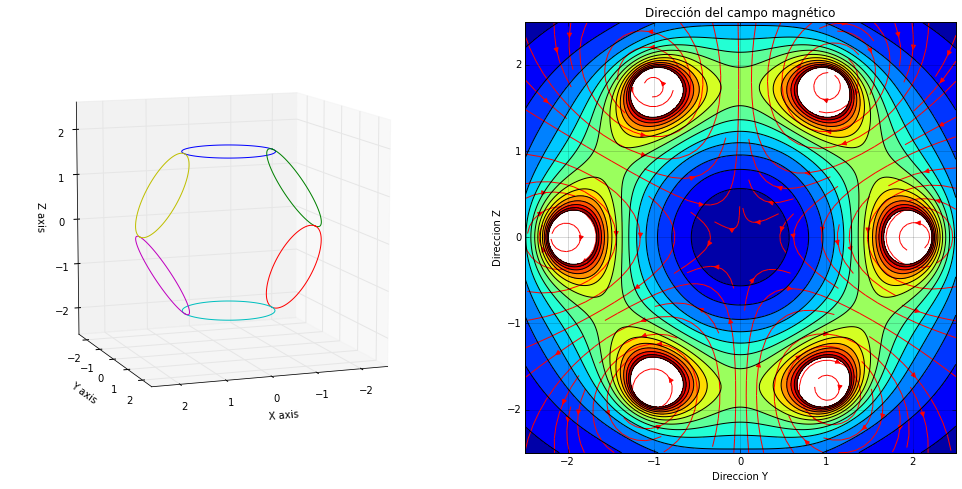

In [90]:
graf_campo(ARGS_hex[0])

## Dinámica de un haz de particulas cargadas que viajan a traves de la lente

Aquí ponemos la ecuación del movimiento de la partícula en el campo magnético:

La fuerza de Lorentz es la fuerza que se ejerce sobre una carga, su ecuación es:

$$\vec{F} = q(\vec{E} + \vec{v} \times \vec{B})$$

En este caso suponemos que no existe ningún campo eléctrico, por lo que la ecuación anterior resulta:

$$\vec{\dot{v}} = \frac{q}{m}\vec{v} \times \vec{B} = q_{m} \vec{v} \times \vec{B}$$

In [10]:
#Se define la ecuacion diferencial para resolver la dinamica de una particula
def carga_en_campo_xyz(entrada, t, ARGS=[1., [1.], [1.], [1.], [0.]]):
    #ARGS tiene el siguiente formato [qm, I, a, h, THETA]
    
    #cómo se llaman las entradas, primero introducimos la posición y luego la velocidad
    x,y,z,vx,vy,vz = entrada[0],entrada[1],entrada[2],entrada[3],entrada[4],entrada[5]
    r = sqrt((x**2) + (y**2))
    phi = arctan2(y, x)
    
    #Se determinan los parametros necesarios para calcular el campo magnetico
    #un parametro adicional aparece, qm el cociente carga entre masa de la particula
    qm, I, a, h, THETA = ARGS[0], ARGS[1], ARGS[2], ARGS[3], ARGS[4]
    
    #Se determina el valor de la bandera
    if r==0: f=1
    else: f=0
    
    Bx, By, Bz = campo(I, a, h, array([x, y, z]), THETA, f)

    #el producto punto entre la fuerza y el campo magnético
    vx_dot = (vy*Bz) - (vz*By)
    vy_dot = (vz*Bx) - (vx*Bz)
    vz_dot = (vx*By) - (vy*Bx)
    
    #la ecuación nos regresa velocidad inicial en x, y, z en ese orden y
    #fuerza en x, y, z
    return [vx,vy,vz, qm*vx_dot, qm*vy_dot, qm*vz_dot]

Se define a continuación la función que se encarga de realizar la simulación de la dinámica de la partícula en el campo magnético.

In [11]:
def dinamica(inicio, t_max, MallaT, ARGS=[1., [1.], [1.], [1.], [0.]], flag=0, flag2=[1,1]):
    #ARGS tiene el siguiente formato [qm, I, a, h, THETA]
    #inicio es la condicion inicial de la particula
    
    #Se calcula el movimiento de la particula en el campo magnetico determinado por los parametros ARGS
    tiempo = linspace(0, t_max, MallaT)
    movimiento = odeint(carga_en_campo_xyz, inicio, tiempo, args = ARGS, rtol=1e-10, atol=1e-12, mxstep=int(1e6))

    #Se hacen 2 graficos, el primero es la proyeccion del movimiento en el plano XY
    # y el segundo el movimiento en el eje Z en funcion del tiempo
    x,y,z = movimiento[:, 0], movimiento[:, 1], movimiento[:, 2]        
    
    #Se definen los parametros del arreglo de espiras
    I, a, h = ARGS[0][1], ARGS[0][2], ARGS[0][3]
    if flag2[0]==1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        ax1.plot(x, y)
        ax1.set_xlabel ('Direccion X') 
        ax1.set_ylabel ('Direccion Y')
        ax1.set_title("Trayectoria en el plano XY")
        ax1.set_aspect('equal', adjustable='box')

        ax2.plot(tiempo, z)
        ax2.set_xlabel ('Tiempo') 
        ax2.set_ylabel ('Direccion Z')
        ax2.set_title("Z en funcion del tiempo")

    if flag2[1]==1:
        #Tambien se grafica la dinamica de la particula en el espacio 3D
        fig = figure(figsize=(10,10))
        ax = fig.gca(projection='3d')

        ax.plot(x, y, z)
        ax1.set_xlim3d(-2, 2)
        ax1.set_ylim3d(inicio[1]-2,inicio[1]+2)
        ax1.set_zlim3d(-2, 2)
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.set_aspect('equal', adjustable='box')
    
        #Se dibujan como referencia el lugar donde se encuentran las espiras
        Angulos = ARGS[4]

        angle = np.linspace(0, 2 * pi, 100)
        for i in range(len(Angulos)):
            M = array([[cos(Angulos[i]), 0., -sin(Angulos[i])],
                       [0., 1., 0.],
                       [sin(Angulos[i]), 0., cos(Angulos[i])]])
            
            X = array([a[i]*cos(angle), a[i]*sin(angle), h[i]*ones(len(angle))])
            RX = dot(M, X)
            ax.plot(RX[0], RX[1], RX[2])
        show()
    
    if flag == 1:
        return movimiento

Para crear un haz de partículas se debe tener una distribución N partículas. En este caso se trata de un circulo de radio 0.7 centrado en el eje $X$ una distancia -G del origen sobre el eje $Y$, las partículas van dirigidas en dirección positiva sobre el eje $Y$.

In [46]:
def dinamica_haz_de_particulas(N, G, t_max, MallaT, spd, vel, ARGS, vista = [10,10]):
    #ARGS tiene el siguiente formato [qm, I, a, h, THETA]
    #inicio es la condicion inicial de la particula  
    fig = figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax1 = fig.add_subplot(1, 2, 2)
    
    tiempo = linspace(0, t_max, MallaT)
    #Se definen los parametros del arreglo de espiras
    I, a, h = ARGS[0][1], ARGS[0][2], ARGS[0][3]
    for i in range(N):
        r, theta = spd*random(), uniform(0,2*pi)
        if len(vel)==1:
            VEL = array([0., uniform(0.2*vel[0],1.2*vel[0]), 0.])
        else:
            VEL = vel
        inicio = [r*cos(theta), G , r*sin(theta), VEL[0], VEL[1], VEL[2]]
        #Se calcula el movimiento de la particula en el campo magnetico determinado por los parametros ARGS
        movimiento = odeint(carga_en_campo_xyz, inicio, tiempo, args = ARGS, rtol=1e-10, atol=1e-12, mxstep=int(1e6))
        x,y,z = movimiento[:, 0], movimiento[:, 1], movimiento[:, 2]
        #Se grafica la dinamica de la particula en el espacio 3D
        ax.plot(x,y,z, markersize=0.5)
        ax1.plot(x, z)
    
    #Se dibujan como referencia el lugar donde se encuentran las espiras
    Angulos = ARGS[0][4]

    angle = np.linspace(0, 2 * pi, 100)
    for i in range(len(Angulos)):
        M = array([[cos(Angulos[i]), 0., -sin(Angulos[i])],
                    [0., 1., 0.],
                    [sin(Angulos[i]), 0., cos(Angulos[i])]])
        X = array([a[i]*cos(angle), a[i]*sin(angle), h[i]*ones(len(angle))])
        RX = dot(M, X)
        ax.plot(RX[0], RX[1], RX[2])
        

    ax.set_xlabel('Direccion X') 
    ax.set_ylabel('Direccion Y') 
    ax.set_zlabel('Direccion Z')
    ax.set_title(u"Trayectoria de las particulas")
    ax.view_init(vista[0],vista[1])

    ax1.set_xlabel('Direccion X') 
    ax1.set_ylabel('Direccion Z')
    ax1.set_aspect('equal', adjustable='box')

    show()

A continuación se muestra la trayectoria de un haz de particulas cargadas, puestos inicialmente en $y=-5$ y con velocidad $\vec{v} = (0, 50, 0)$, el haz tiene un ancho de 0.8. El arreglo por el que se les hace pasar es una lente cuadrupolar donde las espiras tienes diámetro de 1.

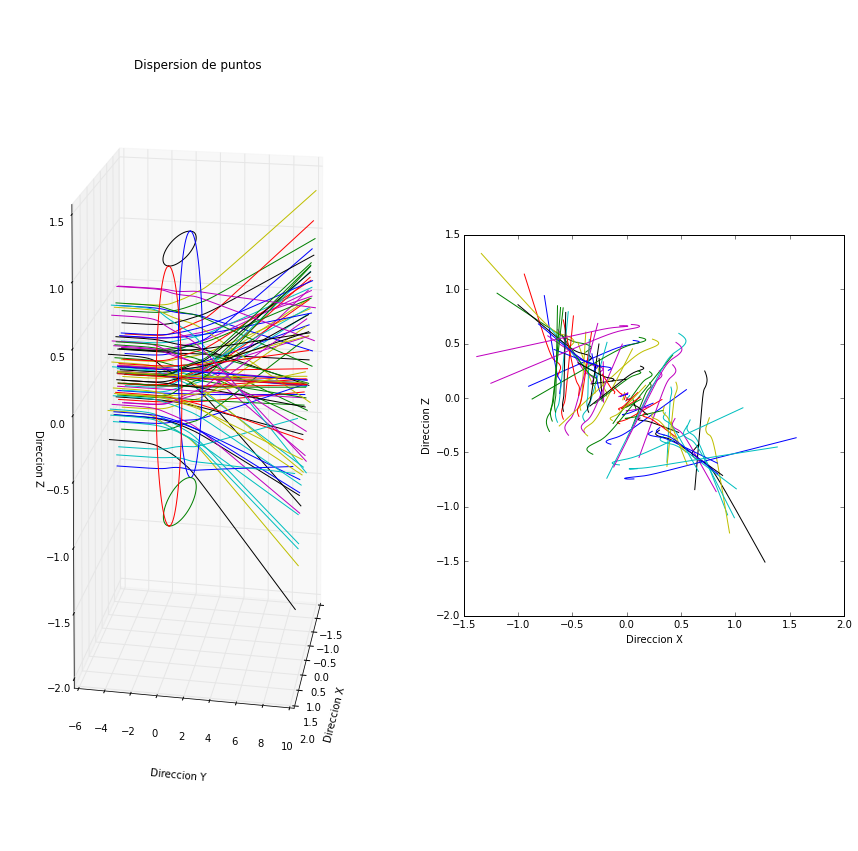

In [37]:
T = 0.3
dinamica_haz_de_particulas(90, -5., T, 1000.*T, 0.8, array([0., 50., 0.]), ARGS_cuad, [10,10])

Como podemos notar, las particulas se enfocar únicamente a lo largo de una diagonal del cuadrupolo, y no a lo largo de la otra diagonal, como era de esperarse.

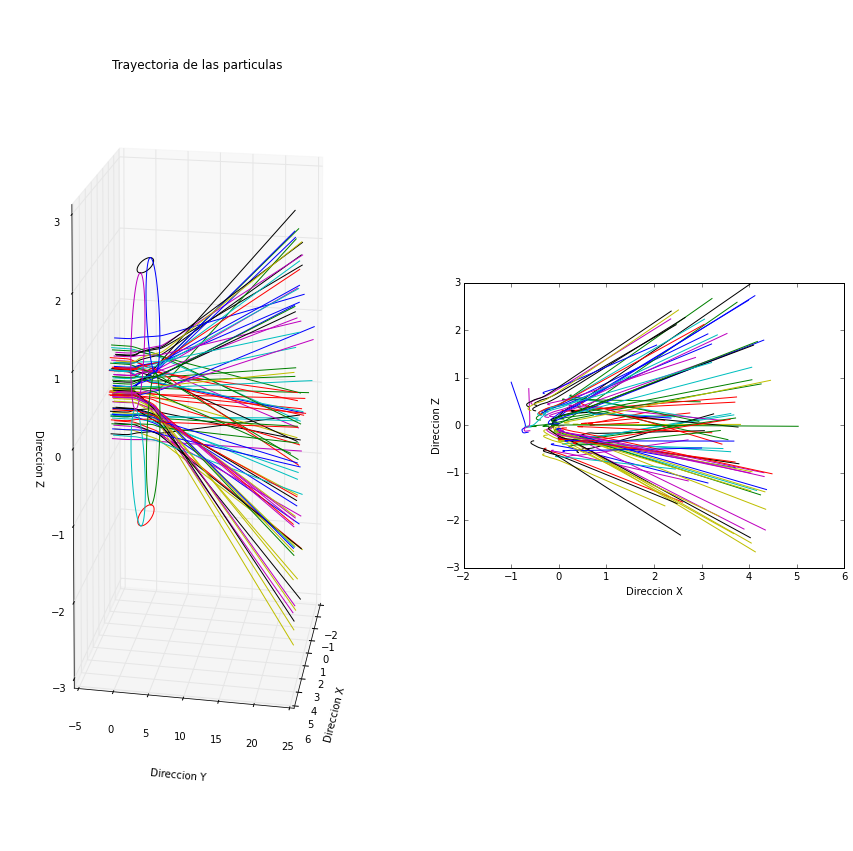

In [109]:
T = 0.6
dinamica_haz_de_particulas(90, -5., T, 1000.*T, 0.8, array([0., 50., 0.]), ARGS_hex, [10,10])

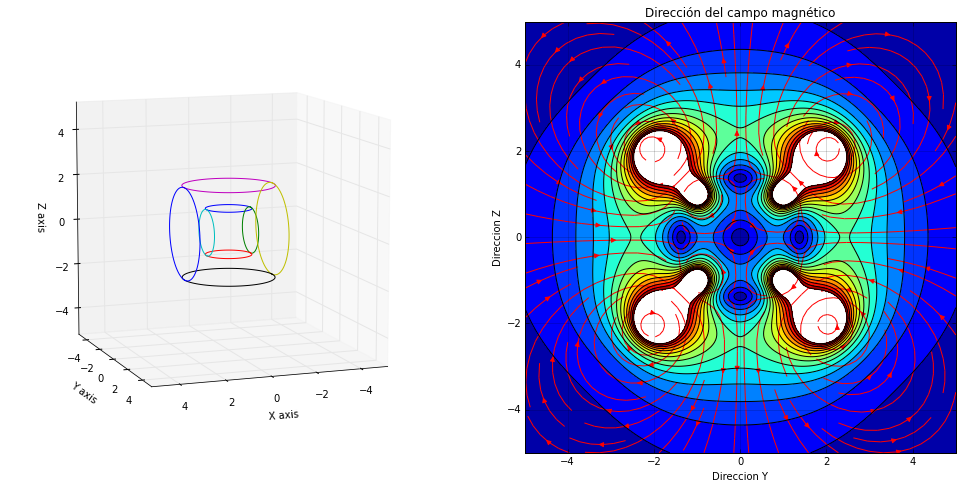

In [130]:
i, qm = 1., -2.
l, m = 2., 2.
I_cuad_doble = [-i, i, i, i, l*i, -l*i, -l*i, -l*i]
a_cuad_doble = [1., 1., 1., 1., m, m, m, m]
h_cuad_doble = [1., 1., 1., 1., m, m, m, m]
THETA_cuad_doble = [0., pi/2, pi, -pi/2, 0., pi/2, pi, -pi/2]
ARGS_cuad_doble = ([qm, I_cuad_doble, a_cuad_doble, h_cuad_doble, THETA_cuad_doble],)

graf_campo(ARGS_cuad_doble[0], [0., 60., 5.], 5., 5.)

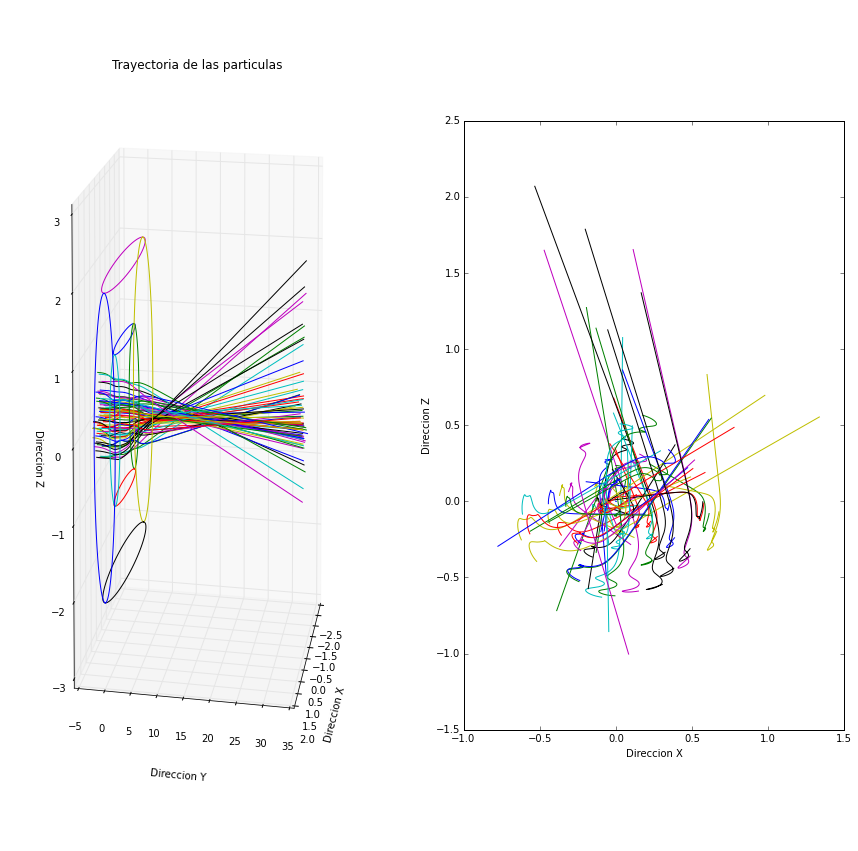

In [142]:
T = 0.8
dinamica_haz_de_particulas(70, -5., T, 1000.*T, 0.7, array([0., 50., 0.]), ARGS_cuad_doble, [10,10])

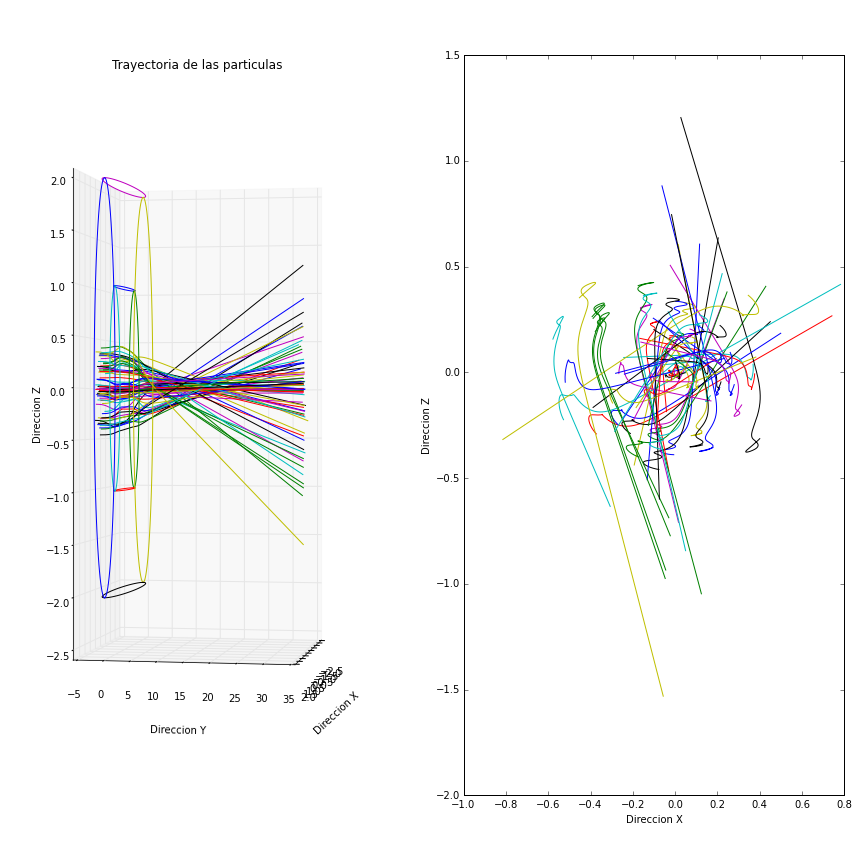

In [144]:
T = 0.8
dinamica_haz_de_particulas(70, -5., T, 1000.*T, 0.6, array([0., 50., 0.]), ARGS_cuad_doble, [0,10])